# Spam Text Classification
## Introduction

In this notebook, we are working on a text classification problem using a dataset of Spam messages and ham messages. The goal is to classify the meesage into their respective categories.

#### Declare dependencies

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.utils import pad_sequences
from keras.utils import to_categorical
import re



#### Load DataFrame

In [2]:
spam_df = pd.read_csv('Spam_SMS.csv')
spam_df.head()

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### Check labels (Our categories to classify)

In [3]:
distinct_labels = spam_df['Class'].unique()
print(distinct_labels)

['ham' 'spam']


#### Tokenize the text

In [4]:
# Convert text data to strings to avoid AttributeError
spam_df['Message'] = spam_df['Message'].astype(str)

# Initialize the tokenizer with a custom filter to remove special characters
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')

# Fit the tokenizer on the text data
tokenizer.fit_on_texts(spam_df['Message'])

# Convert the text to sequences
sequences = tokenizer.texts_to_sequences(spam_df['Message'])

# Print the first 5 sequences to verify
print(sequences[:5])

[[49, 471, 4436, 842, 755, 658, 64, 8, 1327, 88, 123, 351, 1328, 148, 2995, 1329, 67, 58, 4437, 144], [46, 336, 1499, 472, 6, 1941], [47, 489, 8, 19, 4, 797, 901, 2, 176, 1942, 1106, 659, 1943, 2331, 261, 2332, 71, 1942, 2, 1944, 2, 337, 489, 555, 961, 73, 391, 174, 660, 392, 2996], [6, 248, 150, 23, 382, 2997, 6, 139, 154, 57, 150], [1025, 1, 98, 108, 69, 490, 2, 962, 69, 1945, 221, 112, 473]]


#### Encode the labels

In [5]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels
spam_df['label_encoded'] = label_encoder.fit_transform(spam_df['Class'])

# Create a var called label_encoded that contains the encoded labels
label_encoded=spam_df['label_encoded'].to_numpy()

# Print the first 5 rows to verify
print(spam_df.head())


  Class                                            Message  label_encoded
0   ham  Go until jurong point, crazy.. Available only ...              0
1   ham                      Ok lar... Joking wif u oni...              0
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...              1
3   ham  U dun say so early hor... U c already then say...              0
4   ham  Nah I don't think he goes to usf, he lives aro...              0


#### Train test split the sequences and labels

In [6]:
# Split the sequences and label_encoded into training and testing sets
# Split the sequences and label_encoded into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(sequences, label_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting arrays to verify
print(f'X_train shape: {len(X_train)}')
print(f'X_val shape: {len(X_val)}')
print(f'X_test shape: {len(X_test)}')
print(f'y_train shape: {len(y_train)}')
print(f'y_val shape: {len(y_val)}')
print(f'y_test shape: {len(y_test)}')

X_train shape: 3901
X_val shape: 836
X_test shape: 837
y_train shape: 3901
y_val shape: 836
y_test shape: 837


#### Define Max words and Max Length

In [7]:
# Define the maximum number of words and the maximum sequence length
max_words = 3000
max_len = 100

#### Adapt Sequences and labels

In [8]:
# Pad the sequences to ensure uniform input size (this put a 0 in front of the sequence to make them all the same length)
X_train_padded = pad_sequences(X_train, maxlen=max_len)
X_test_padded = pad_sequences(X_test, maxlen=max_len)
X_val_padded = pad_sequences(X_val, maxlen=max_len)

# Convert labels to categorical format (this change the label to a one-hot encoded format e.g [0,0,1,0])
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)
y_val_categorical = to_categorical(y_val)

### Model
#### Defining and Fitting

In [10]:
# Define the model
model = Sequential()
model.add(Embedding(max_words, 100, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train_padded, y_train_categorical, epochs=5, batch_size=64, validation_data=(X_val_padded, y_val_categorical))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          300000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 100, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 380,602
Trainable params: 380,602
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
61/61 [==============================] - 10s 28ms/step - loss: 0.2416 - accuracy: 0.9121 - val_loss: 0.0

#### Testing Accuracy on test data

In [11]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_padded, y_test_categorical, verbose=0)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Test Loss: 0.0392129048705101
Test Accuracy: 0.9880525469779968


#### Plot a graph to show loss and accuracy over each epoch of the model

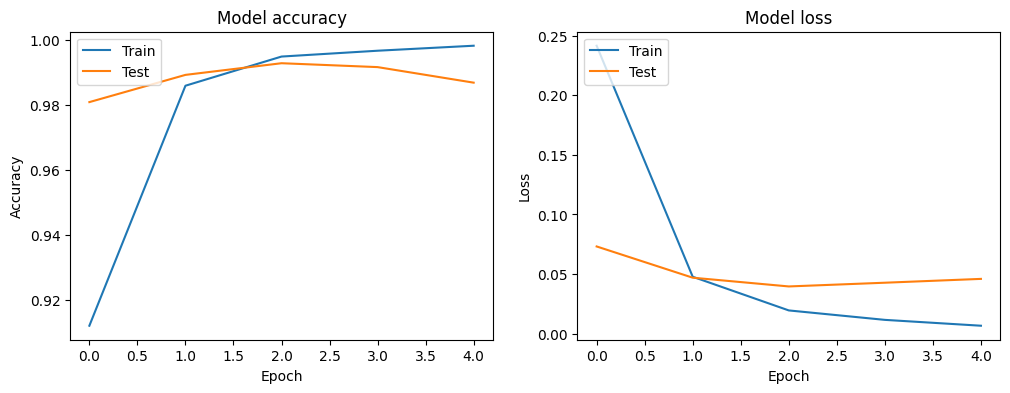

In [12]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

#### Predict one test data only

In [13]:
# Select a single test sample
sample_index = 5
sample = X_test_padded[sample_index].reshape(1, -1)

# Predict the label for the sample
predicted_probabilities = model.predict(sample)
predicted_label = predicted_probabilities.argmax(axis=-1)
real_label = y_test[sample_index]

# Decode the predicted label to its original category
predicted_category = label_encoder.inverse_transform(predicted_label)
predicted_real = label_encoder.inverse_transform([real_label])

print(f'Predicted label: {predicted_label[0]}')
print(f'Predicted category: {predicted_category[0]}')
print(f'Real label: {real_label}')
print(f'Real category: {predicted_real[0]}')

1/1 [==============================] - 0s 242ms/step
Predicted label: 1
Predicted category: spam
Real label: 1
Real category: spam


#### Predict all test data

In [14]:
# Predict the labels for all samples in X_test_padded
predicted_probabilities_all = model.predict(X_test_padded)
predicted_labels_all = predicted_probabilities_all.argmax(axis=-1)

# Decode the predicted labels to their original categories
predicted_categories_all = label_encoder.inverse_transform(predicted_labels_all)

# Print the first 10 predictions to verify
for i in range(10):
    print(f'Sample {i}: Predicted Category: {predicted_categories_all[i]}, Real Category: {label_encoder.inverse_transform([y_test[i]])[0]}')

27/27 [==============================] - 0s 9ms/step
Sample 0: Predicted Category: ham, Real Category: ham
Sample 1: Predicted Category: ham, Real Category: ham
Sample 2: Predicted Category: spam, Real Category: spam
Sample 3: Predicted Category: ham, Real Category: ham
Sample 4: Predicted Category: ham, Real Category: ham
Sample 5: Predicted Category: spam, Real Category: spam
Sample 6: Predicted Category: ham, Real Category: ham
Sample 7: Predicted Category: ham, Real Category: ham
Sample 8: Predicted Category: ham, Real Category: ham
Sample 9: Predicted Category: ham, Real Category: ham


#### Plot test labels versus predictions

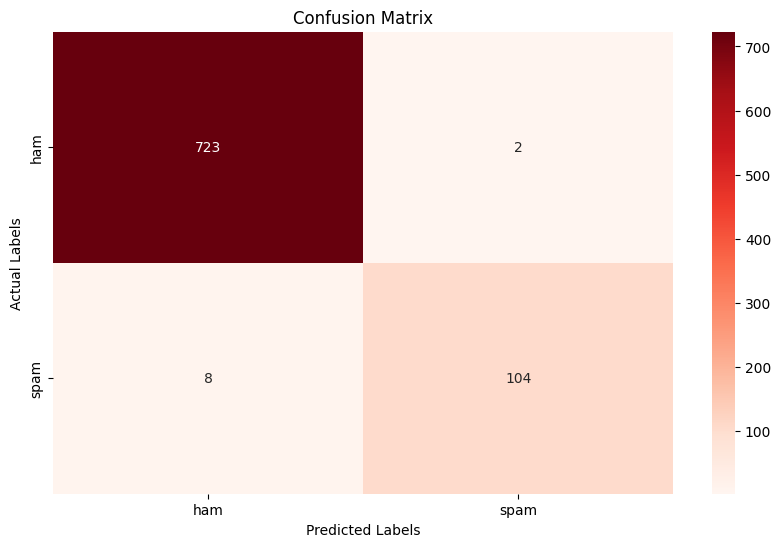

In [16]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels_all)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()


## Conclusion

In this notebook, we successfully built and evaluated a text classification model using a dataset of spam messages and ham messages. The workflow included the following steps:

1. **Data Loading and Preprocessing**: We loaded the dataset, converted text data to sequences using a tokenizer, and encoded the labels.
2. **Data Splitting**: We split the data into training and testing sets.
3. **Model Building**: We constructed a Sequential model using Keras with an embedding layer, LSTM layer, and dense output layer.
4. **Model Training**: We trained the model on the training data and validated it on the test data.
5. **Evaluation**: We evaluated the model's performance using accuracy and loss metrics.
6. **Visualization**: We visualized the training and validation accuracy and loss over epochs.
7. **Prediction and Analysis**: We made predictions on the test data, decoded the predicted labels, and analyzed the results using a confusion matrix.

The model achieved a high accuracy of 98.8% on the test data, indicating its effectiveness in classifying spam messages.
